In [1]:
# Standard imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from datetime import datetime
import csv

# Imports for curve fitting
from iminuit import Minuit
from scipy.integrate import quad

# Keras imports
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
def load_dataset(a, b):
    #
    num_snaps = 20000
    tdiff = 9.0
    grid_dataset_list = []
    file_index = 1
    #alphas = np.linspace(0.2, 0.8, 4)
    #betas = np.linspace(0.2, 0.8, 4)
    
    grid_pt_data = pd.read_csv("SlowSiteRealTimeSnaps{}alpha{}beta{}tdiff{}.csv".format(num_snaps, a, b, tdiff), header=None)
    grid_pt_data['y'] = [file_index] * grid_pt_data.shape[0]
    grid_dataset_list.append(grid_pt_data)
    #print('Alpha, Beta is {} and given label {}'.format((a, b), file_index))
    file_index += 1
    
    grid_dataset = pd.concat(grid_dataset_list)

    X = grid_dataset.iloc[:, :-1]
    y = grid_dataset.iloc[:, -1]
    
    return X, y, file_index

In [3]:
class VAE:
    #
    def __init__(self, idnum, original_dim=100, intermediate_dim1=75, intermediate_dim2=50, latent_dim=1):
        #
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim1 = intermediate_dim1
        self.intermediate_dim2 = intermediate_dim2
        self.idnum = idnum
        
    def sampling(self, args):
        # Unpack arguments
        z_mean, z_log_var = args
        # Get shape of random noise to sample
        epsilon = K.random_normal(shape=K.shape(z_mean))
        # Return samples from latent space p.d.f.
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    def build_vae(self):
        #
        original_dim = self.original_dim
        latent_dim = self.latent_dim
        intermediate_dim1 = self.intermediate_dim1
        intermediate_dim2 = self.intermediate_dim2
        
        # encoder
        inputs = Input(original_dim, name='input')
        x = Dense(intermediate_dim1, activation='relu')(inputs)
        x = Dense(intermediate_dim2, activation='relu')(x)
        z_mean = Dense(latent_dim, name="z_mean")(x)
        z_log_var = Dense(latent_dim, name="z_log_var")(x)
        z = Lambda(self.sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        
        #decoder
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
        x = Dense(intermediate_dim2, activation='relu')(latent_inputs)
        x = Dense(intermediate_dim1, activation='relu')(x)
        outputs = Dense(original_dim, activation='sigmoid')(x)
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        
        i = self.encoder.inputs
        if len(i) == 1:
            i = i[0]
            pass
        z = self.encoder(i)[2]
        o = self.decoder(z)
        self.vae = Model(i, o, name='VAE'+str(self.idnum))
        
    def compile_vae(self):
        # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
        encoder   = self.vae.get_layer('encoder')
        z_log_var = encoder.get_layer('z_log_var').output
        z_mean    = encoder.get_layer('z_mean').output

        # Define reconstruction loss
        def reco_loss(y_true, y_pred):
            # Use binary cross-entropy loss
            reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
            reco_loss_value = K.sum(reco_loss_value)
            return reco_loss_value

        # Define Kullback-Leibler loss with reference to encoder output layers
        def kl_loss(y_true, y_pred):
            kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
            kl_loss_value = K.sum(kl_loss_value, axis=-1)
            return kl_loss_value

        # Define VAE loss
        def vae_loss(y_true, y_pred):
            return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

        self.vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
        return
    
    def get_summaries(self):
        #
        return [self.encoder.summary(),
                self.decoder.summary(),
                self.vae.summary()]
    
    def get_architectures(self):
        #
        return [plot_model(self.encoder, show_shapes=True),
                plot_model(self.decoder, show_shapes=True),
                plot_model(self.vae, show_shapes=True)]

In [4]:
lat_length = 100
#zstart = -4.
#zstop = 4.
#znum = 1000
#zrange = np.linspace(zstart, zstop, znum)
num_pts = 200

In [5]:
def config_taus(rhos):
    #
    taus = np.zeros(lat_length)
    for i in range(lat_length):
        if random.random() <= rhos[i]:
            taus[i] = 1
    return taus

In [6]:
def calc_mfpoftaus(rhos, taus):
    #
    return np.prod(rhos**taus * (1-rhos)**(1-taus))

In [7]:
def calc_complexity1(z_samples, decoder):
    avg_1 = 0
    for i in range(num_pts):
        sample0 = random.choice(z_samples)
        rhos0 = decoder.predict(np.array([sample0]))[0]  
        taus0 = config_taus(rhos0)
        avg_0 = 0
        for i in range(num_pts):
            sample1 = random.choice(z_samples)
            rhos1 = decoder.predict(np.array([sample1]))[0]  
            avg_0 += calc_mfpoftaus(rhos1, taus0)
        avg_0 /= num_pts
        avg_1 += np.log(avg_0)
    avg_1 /= num_pts
    
    avg_2 = 0
    for i in range(num_pts):
        sample2 = random.choice(z_samples)
        rhos2 = decoder.predict(np.array([sample2]))[0]
        avg_0b = 0
        for i in range(num_pts):
            sample_prime = random.choice(z_samples)
            rhos_prime = decoder.predict(np.array([sample_prime]))[0]
            taus_prime = config_taus(rhos_prime)
            avg_0b += np.log(calc_mfpoftaus(rhos2, taus_prime))
        avg_0b /= num_pts
        avg_2 += avg_0b
    avg_2 /= num_pts
    
    return avg_1 - avg_2

In [8]:
def calc_complexity2(z_samples, decoder):
    avg_A = 0
    for i in range(num_pts):
        sample_A = random.choice(z_samples)
        rhos_A = decoder.predict(np.array([sample_A]))[0]
        sum_A = np.sum(rhos_A*np.log(rhos_A) + (1-rhos_A)*np.log(1-rhos_A))
        avg_A += sum_A
    avg_A /= num_pts
    
    avg_rhos = 0
    for i in range(num_pts):
        sample_B = random.choice(z_samples)
        rhos_B = decoder.predict(np.array([sample_B]))[0]
        avg_rhos += rhos_B
    avg_rhos /= num_pts
    sum_B = np.sum(avg_rhos*np.log(avg_rhos) + (1-avg_rhos)*np.log(1-avg_rhos))
    
    return avg_A - sum_B

In [9]:
def plot_z_example(z, decoder, name, ax):
    #
    ax.scatter(list(range(100)), decoder.predict(np.array([z])), label=name+' z = '+str(z))
    ax.set_ylim(0, 1)
    ax.legend()

In [10]:
def one_experiment():

    X_trains = []
    X_tests = []
    y_trains = []
    y_tests = []

    X1, y1, file_index1 = load_dataset(1.0, 1.0)
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.5)
    X_trains.append(X1_train)
    X_tests.append(X1_test)
    y_trains.append(y1_train)
    y_trains.append(y1_train)

    

    VAEs = []
    for i in range(len(X_trains)):
        Vae = VAE(i)
        Vae.build_vae()
        Vae.compile_vae()
        VAEs.append(Vae)

    nb_epochs  = 10
    batch_size = 32

    histories = []
    for i in range(len(VAEs)):
        history = VAEs[i].vae.fit(X_trains[i], X_trains[i],
                                  epochs=nb_epochs,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  validation_split=0.2,
                                  verbose=False)
        histories.append(history)
    
    example_zs = np.array([-3., -1., 0., 1., 3.])
    fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20,5))
    fig.suptitle('Example density profiles')
    fig.supxlabel('site')
    fig.supylabel(r'$\rho$')

    for i in range(len(example_zs)):
        plot_z_example(example_zs[i], VAEs[0].decoder, 'Slow site', axs[i])

    zsamples_list = []
    for i in range(len(VAEs)):
        _, _, zsamples = VAEs[i].encoder.predict(X_tests[i])
        zsamples_list.append(zsamples)

    complexities1 = []
    for i in range(len(zsamples_list)):
        complexity1 = calc_complexity1(zsamples_list[i], VAEs[i].decoder)
        complexities1.append(complexity1)
        print('Done complexity1: ',i)

    complexities2 = []
    for i in range(len(zsamples_list)):
        complexity2 = calc_complexity2(zsamples_list[i], VAEs[i].decoder)
        complexities2.append(complexity2)
        print('Done complexity2: ',i)

    for i in range(len(complexities1)):
        print('{},{},{},{}'.format(i,
                                   histories[i].history['val_kl_loss'][-1],
                                   complexities1[i],
                                   complexities2[i]))

    complexities0 = []
    for i in range(len(histories)):
        complexities0.append(histories[i].history['val_kl_loss'][-1])

    # Highest to lowest complexity
    c0_ranked = (-np.array(complexities0)).argsort()
    c1_ranked = (-np.array(complexities1)).argsort()
    c2_ranked = (-np.array(complexities2)).argsort()

    print('validation_KL: ',c0_ranked)
    print('complexity1: ',c1_ranked)
    print('complexity2: ',c2_ranked)
    
    csvrow = []
    for i in range(len(complexities0)):
        csvrow.append(complexities0[i])
        csvrow.append(complexities1[i])
        csvrow.append(complexities2[i])
    
    return csvrow

In [11]:
num_experiments = 1

run  1


C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Done complexity1:  0
Done complexity2:  0
0,0.00036067856126464903,0.6174725083586345,-0.0027435207366934833
validation_KL:  [0]
complexity1:  [0]
complexity2:  [0]


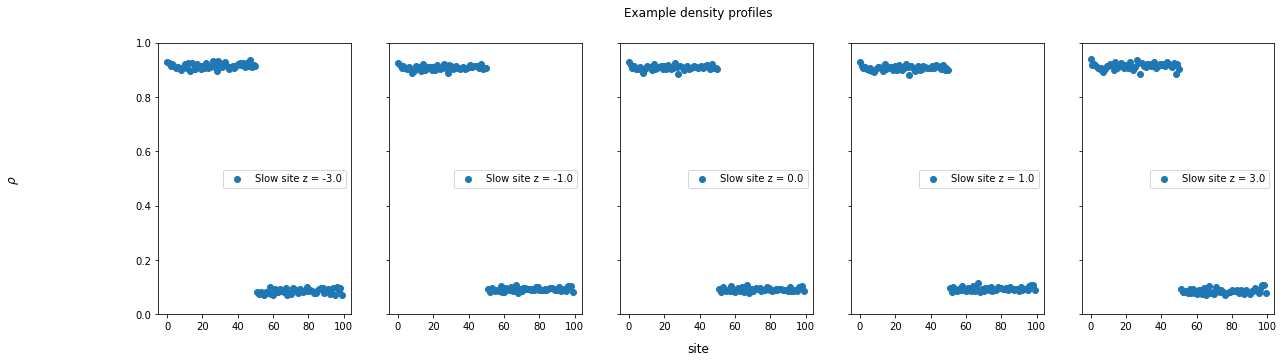

In [12]:
# write to csv file
csvtitle = ['# Slow Site Complexity']
csvheader = ['experiment',
             'MF1C0', 'MF1C1', 'MF1C2', 'MF2C0', 'MF2C1', 'MF2C2',
             'MF3C0', 'MF3C1', 'MF3C2', 'MF4C0', 'MF4C1', 'MF4C2'
             ]

with open('Slow_site_complexity_data.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(csvtitle)
    writer.writerow(csvheader)
    for i in range(num_experiments):
        print('run ', i+1)
        writer.writerow([i+1]+ one_experiment())